In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

Unofficial Lecture Note by @timlee

- http://forums.fast.ai/t/deeplearning-lecnotes6/8641
- http://forums.fast.ai/t/deeplearning-lec7notes/8939

Lecture note by Hiromi.Suenaga is helpful, too.

- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-6-de70d626976c
- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-7-1b9503aff0c

## Setup

We're going to download the collected works of Nietzsche to use as our data for this class.

In [2]:
PATH='data/nietzsche/'

In [3]:
os.makedirs(f'{PATH}', exist_ok=True)

In [4]:
get_data("https://s3.amazonaws.com/text-datasets/nietzsche.txt", f'{PATH}nietzsche.txt')
text = open(f'{PATH}nietzsche.txt').read()
print('corpus length:', len(text))

corpus length: 600893


In [5]:
text[:400]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unskilled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself '

In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 85


Sometimes it's useful to have a zero value in the dataset, e.g. for padding

In [7]:
chars.insert(0, "\0")

''.join(chars[1:-6])

'\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxy'

Map from chars to indices and back again

In [8]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

*idx* will be the data we use from now own - it simply converts all the characters to their index (based on the mapping above)

In [9]:
idx = [char_indices[c] for c in text]

idx[:10]

[40, 42, 29, 30, 25, 27, 29, 1, 1, 1]

In [10]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

## Three char model

### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [11]:
cs=3
c1_dat = [idx[i]   for i in range(0, len(idx)-cs, cs)]    # 0,3,6,..
c2_dat = [idx[i+1] for i in range(0, len(idx)-cs, cs)] # 1,4,7,..
c3_dat = [idx[i+2] for i in range(0, len(idx)-cs, cs)] # 2,5,8,..
c4_dat = [idx[i+3] for i in range(0, len(idx)-cs, cs)] # 3,6,9,..

Our inputs

In [13]:
x1 = np.stack(c1_dat) # (200297,)
x2 = np.stack(c2_dat) # (200297,)
x3 = np.stack(c3_dat) # (200297,)

Our output

In [14]:
y = np.stack(c4_dat) # (200297,)

The first 4 inputs and outputs

In [15]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

In [16]:
y[:4]

array([30, 29,  1, 40])

In [17]:
x1.shape, y.shape

((200297,), (200297,))

### Create and train model

Pick a size for our hidden state

In [18]:
n_hidden = 256

The number of latent factors to create (i.e. the size of the embedding matrix)

In [19]:
n_fac = 42

In [20]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)

        # The 'green arrow' from our diagram - the layer operation from input to hidden
        self.l_in = nn.Linear(n_fac, n_hidden)

        # The 'orange arrow' from our diagram - the layer operation from hidden to hidden
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        
        # The 'blue arrow' from our diagram - the layer operation from hidden to output
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h)) # (batch size, vocab_size)

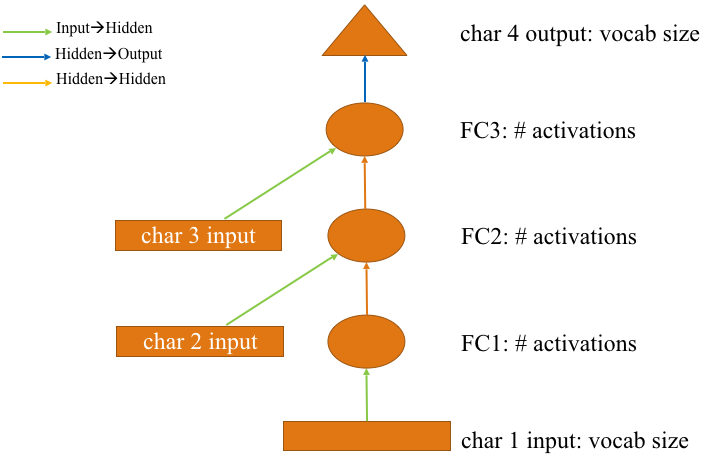

In [21]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512) # '.': path, [-1]: val_idxs

In [22]:
m = Char3Model(vocab_size, n_fac).cuda()

In [23]:
it = iter(md.trn_dl)
*xs,yt = next(it) # xs:  [[512], [512], [512]], yt: [512]
t = m(*V(xs)) # [batch size, vocab size])

In [1]:
# Sample usage of starred assignment
#def example_starred_assignment():
#    return 1, 2

#*a, b = example_starred_assignment()
#>>>a
# [1]
#>>>b
# 2

#a, b = example_starred_assignment()
#>>> a
# 1
#>>>b 
# 2

In [24]:
opt = optim.Adam(m.parameters(), 1e-2)

In [25]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.102897   0.971233  



[0.9712329]

In [26]:
set_lrs(opt, 0.001)

In [27]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.846745   0.592908  



[0.5929079]

### Test model

In [29]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    # def VV(x):  return [VV_(o) for o in x] if isinstance(x,list) else VV_(x)
    # def VV_(x): return create_variable(x, True)
    # def create_variable(x, volatile, requires_grad=False):
    # if not isinstance(x, Variable):
    #     x = Variable(T(x), volatile=volatile, requires_grad=requires_grad)
    # return x
    p = m(*VV(idxs)) 
    i = np.argmax(to_np(p))
    return chars[i]

In [30]:
get_next('y. ')

'T'

In [31]:
get_next('ppl')

'e'

In [32]:
get_next(' th')

'e'

In [33]:
get_next('and')

' '

## Our first RNN!

### Create inputs

This is the size of our unrolled RNN.

In [34]:
cs=8 # input sequence length

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to out model.

In [35]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs)] # [[0,1,2,3,4,5,6,7], [1,2,3,4,5,6,7,8], ...]

Then create a list of the next character in each of these series. This will be the labels for our model.

In [36]:
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs)] # [8, 9,..]

In [37]:
xs = np.stack(c_in_dat, axis=0)

In [38]:
xs.shape

(600885, 8)

In [39]:
y = np.stack(c_out_dat) # (600885,)

So each column below is one series of 8 characters from the text.

In [40]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])

...and this is the next character after each sequence.

In [41]:
y[:cs]

array([ 1,  1, 43, 45, 40, 40, 39, 43])

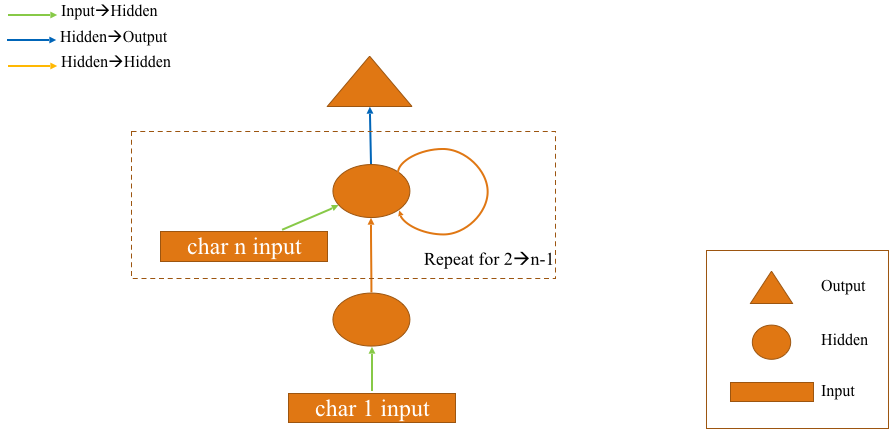

### Create and train model

In [42]:
val_idx = get_cv_idxs(len(idx)-cs-1)

In [43]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

In [44]:
class CharLoopModel(nn.Module):
    # This is an RNN!
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs): # [8, batch_size]
        bs = cs[0].size(0) # 512
        h = V(torch.zeros(bs, n_hidden).cuda()) 
        for c in cs:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp)) # [batch_size, n_hidden]  adding h and inp together, we might lose information
        return F.log_softmax(self.l_out(h), dim=-1) # [batch_size, vocab size]

In [45]:
m = CharLoopModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [46]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs)) # [batch size, vocab size])

In [47]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.001653   2.004431  



[2.0044308]

In [48]:
set_lrs(opt, 0.001)

In [49]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.698835   1.690984  



[1.6909841]

In [50]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs): # [8, batch_size]
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            inp = torch.cat((h, self.e(c)), 1) # [batch_size, n_hidden + n_fac]
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1) # [batch_size, vocab_size]

In [51]:
m = CharLoopConcatModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [52]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs)) # [batch_size, vocab_size]

In [53]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.793336   1.762263  



[1.7622632]

In [54]:
set_lrs(opt, 1e-4)

In [55]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.684172   1.680254  



[1.680254]

### Test model

In [56]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [57]:
get_next('for thos')

'e'

In [58]:
get_next('part of ')

't'

In [59]:
get_next('queens a')

'n'

## RNN with pytorch

In [60]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden) # RNN layer, See https://mosko.tokyo/post/pytorch-rnn/ to know what is difference between RNN layer and RNN cell
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs): # [sequence length(8), batch_size]
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs)) # [sequence length, batch_size, n_fac]
        
        # each of 8 RNN cells output [batch_size, n_hidden]
        outp,h = self.rnn(inp, h) # [sequence length, batch_size, n_hidden], [1, batch_size, n_hidden]
        
        # outp[-1]: last of output sequence(8 length)
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)  # [batch_size, vocab_size]

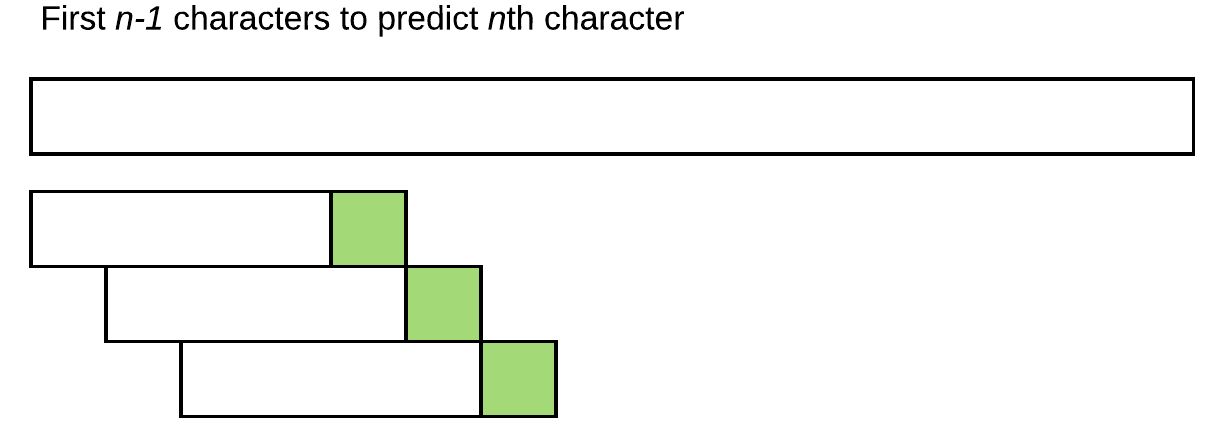

In [61]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [62]:
it = iter(md.trn_dl)
*xs,yt = next(it) # xs: [8, batch_size], yt: [batch_size]

In [63]:
t = m.e(V(torch.stack(xs)))
t.size() # [sequence length, batch_size, n_fac]

torch.Size([8, 512, 42])

In [64]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size() # [sequence length, batch_size, n_hidden], [1, batch_size, n_hidden]   hidden state is rank-3 tensor. 

(torch.Size([8, 512, 256]), torch.Size([1, 512, 256]))

In [65]:
t = m(*V(xs)); t.size() # [batch_size, vocab_size]

torch.Size([512, 85])

In [66]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.864592   1.84589   
    1      1.677635   1.669318                              
    2      1.581888   1.591804                              
    3      1.523863   1.554535                              



[1.5545353]

In [67]:
set_lrs(opt, 1e-4)

In [68]:
fit(m, md, 2, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.467053   1.510775  
    1      1.460249   1.504909                              



[1.5049086]

### Test model

In [69]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp])) 
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [70]:
get_next('for thos')

'e'

In [71]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [72]:
get_next_n('for thos', 40)

'for those and the same the same the same the sam'

## Multi-output model

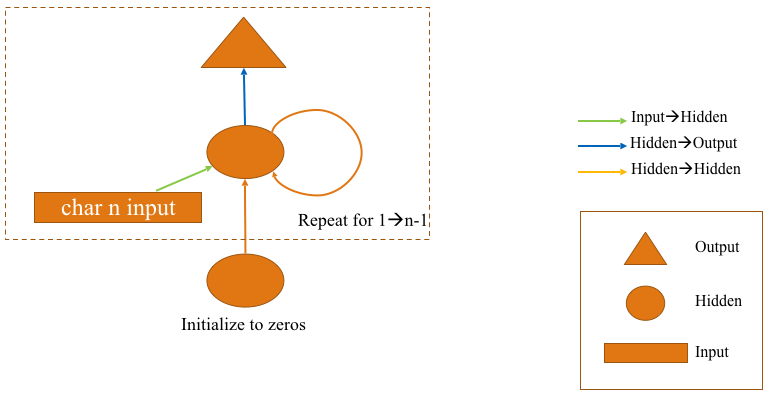

### Setup

Let's take non-overlapping sets of characters this time

In [73]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)] # [[0,1,2,3,4,5,6,7], [8,9,10,11,12,13,14,15], ...]

Then create the exact same thing, offset by 1, as our labels

In [74]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)] # [[1,2,3,4,5,6,7,8], [9,10,11,12,13,14,15,16], ...]  1character shifted

In [75]:
xs = np.stack(c_in_dat)
xs.shape

(75111, 8)

In [76]:
ys = np.stack(c_out_dat)
ys.shape

(75111, 8)

In [77]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [33, 38, 31,  2, 73, 61, 54, 73],
       [ 2, 44, 71, 74, 73, 61,  2, 62],
       [72,  2, 54,  2, 76, 68, 66, 54],
       [67,  9,  9, 76, 61, 54, 73,  2],
       [73, 61, 58, 67, 24,  2, 33, 72],
       [ 2, 73, 61, 58, 71, 58,  2, 67]])

In [78]:
ys[:cs,:cs]

array([[42, 29, 30, 25, 27, 29,  1,  1],
       [ 1, 43, 45, 40, 40, 39, 43, 33],
       [38, 31,  2, 73, 61, 54, 73,  2],
       [44, 71, 74, 73, 61,  2, 62, 72],
       [ 2, 54,  2, 76, 68, 66, 54, 67],
       [ 9,  9, 76, 61, 54, 73,  2, 73],
       [61, 58, 67, 24,  2, 33, 72,  2],
       [73, 61, 58, 71, 58,  2, 67, 68]])

### Create and train model

In [79]:
val_idx = get_cv_idxs(len(xs)-cs-1)

In [80]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [81]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs): # [8(sequence length), batch_size]
        bs = cs[0].size(0) 
        h = V(torch.zeros(1, bs, n_hidden)) # reset hidden state
        inp = self.e(torch.stack(cs)) # [8, batch_size, n_fac]
        outp,h = self.rnn(inp, h) # [8, batch_size, n_hidden], [1, batch_size, n_hidden]
        return F.log_softmax(self.l_out(outp), dim=-1) # [8, batch_size, vocab_size], dim=-1 means last axis

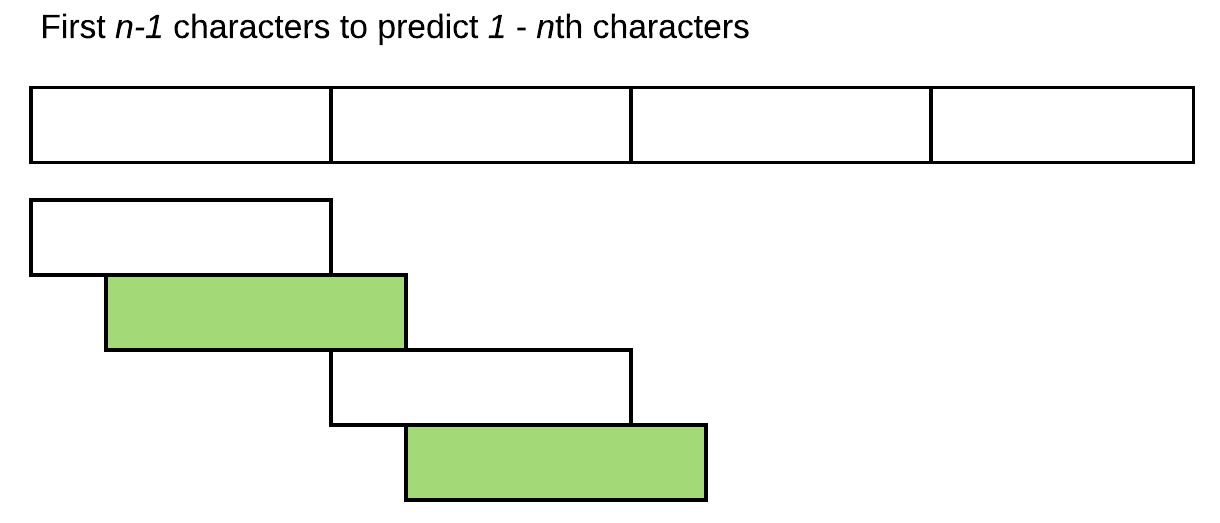

In [82]:
m = CharSeqRnn(vocab_size, n_fac).cuda() 
opt = optim.Adam(m.parameters(), 1e-3)

In [83]:
it = iter(md.trn_dl)
*xst,yt = next(it) # xst: [len(8), batch_size] , yt: [batch_size, 8] 

In [84]:
def nll_loss_seq(inp, targ):# targ: [batch_size, 8]
    sl,bs,nh = inp.size() # sequence length(8), batch size(512), vocab_size(85) 
    
    # [batch_size, 8] ->(transpose)-> [8, batch_size] ->(view)-> [4096]
    targ = targ.transpose(0,1).contiguous().view(-1) # view() is same as np.reshape()
    
    # Definition of F.nll_loss: http://pytorch.org/docs/master/_modules/torch/nn/functional.html#nll_loss
    #    input: (N, number of classes)
    #    target: (N) where each value is class number
    return F.nll_loss(inp.view(-1,nh), targ)

In [85]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.582134   2.397642  
    1      2.279578   2.190767                              
    2      2.129782   2.079566                              
    3      2.042234   2.00667                               



[2.00667]

In [86]:
set_lrs(opt, 1e-4)

In [87]:
fit(m, md, 1, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.992193   1.993106  



[1.9931062]

### Identity init!

In [88]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2) # we use bigger learning rate than previous model's parameter (1e-3)

In [89]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden)) # initialize weight with identity matrix


    1     0     0  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      1     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 256x256 (GPU 0)]

In [90]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      2.37708    2.216203  
    1      2.106199   2.051645                              
    2      1.994551   1.969547                              
    3      1.934305   1.940193                              



[1.9401926]

In [91]:
set_lrs(opt, 1e-3)

In [92]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.842366   1.858213  
    1      1.833924   1.850397                              
    2      1.824675   1.844171                              
    3      1.817116   1.838578                              



[1.8385781]

## Stateful model

### Setup

In [93]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

PATH='data/nietzsche/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

models/  nietzsche.txt  trn/  val/


In [94]:
# http://forums.fast.ai/t/deeplearning-lec7notes/8939

os.makedirs(f'{PATH}{TRN_PATH}', exist_ok=True)
os.makedirs(f'{PATH}{VAL_PATH}', exist_ok=True)

# Breaking up our text into 80% train and 20% test
with open('data/nietzsche/nietzsche.txt') as f:
    text = f.readlines()
    text_line_length = len(text)
    trn_index = int(text_line_length*.8)
    trn = text[:trn_index]
    tst = text[trn_index:]
    with open('data/nietzsche/trn/trn.txt','w') as f2:
        f2.writelines(trn)
    with open('data/nietzsche/val/val.txt','w') as f3:
        f3.writelines(tst)  

In [95]:
%ls {PATH}trn

trn.txt


In [96]:
TEXT = data.Field(lower=True, tokenize=list)
bs=64; bptt=8; n_fac=42; n_hidden=256

FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text) #  len(md.trn_dl): how many mini-batches in epoch, md.nt = len(field.vocab)

(942, 55, 1, 482972)

### RNN

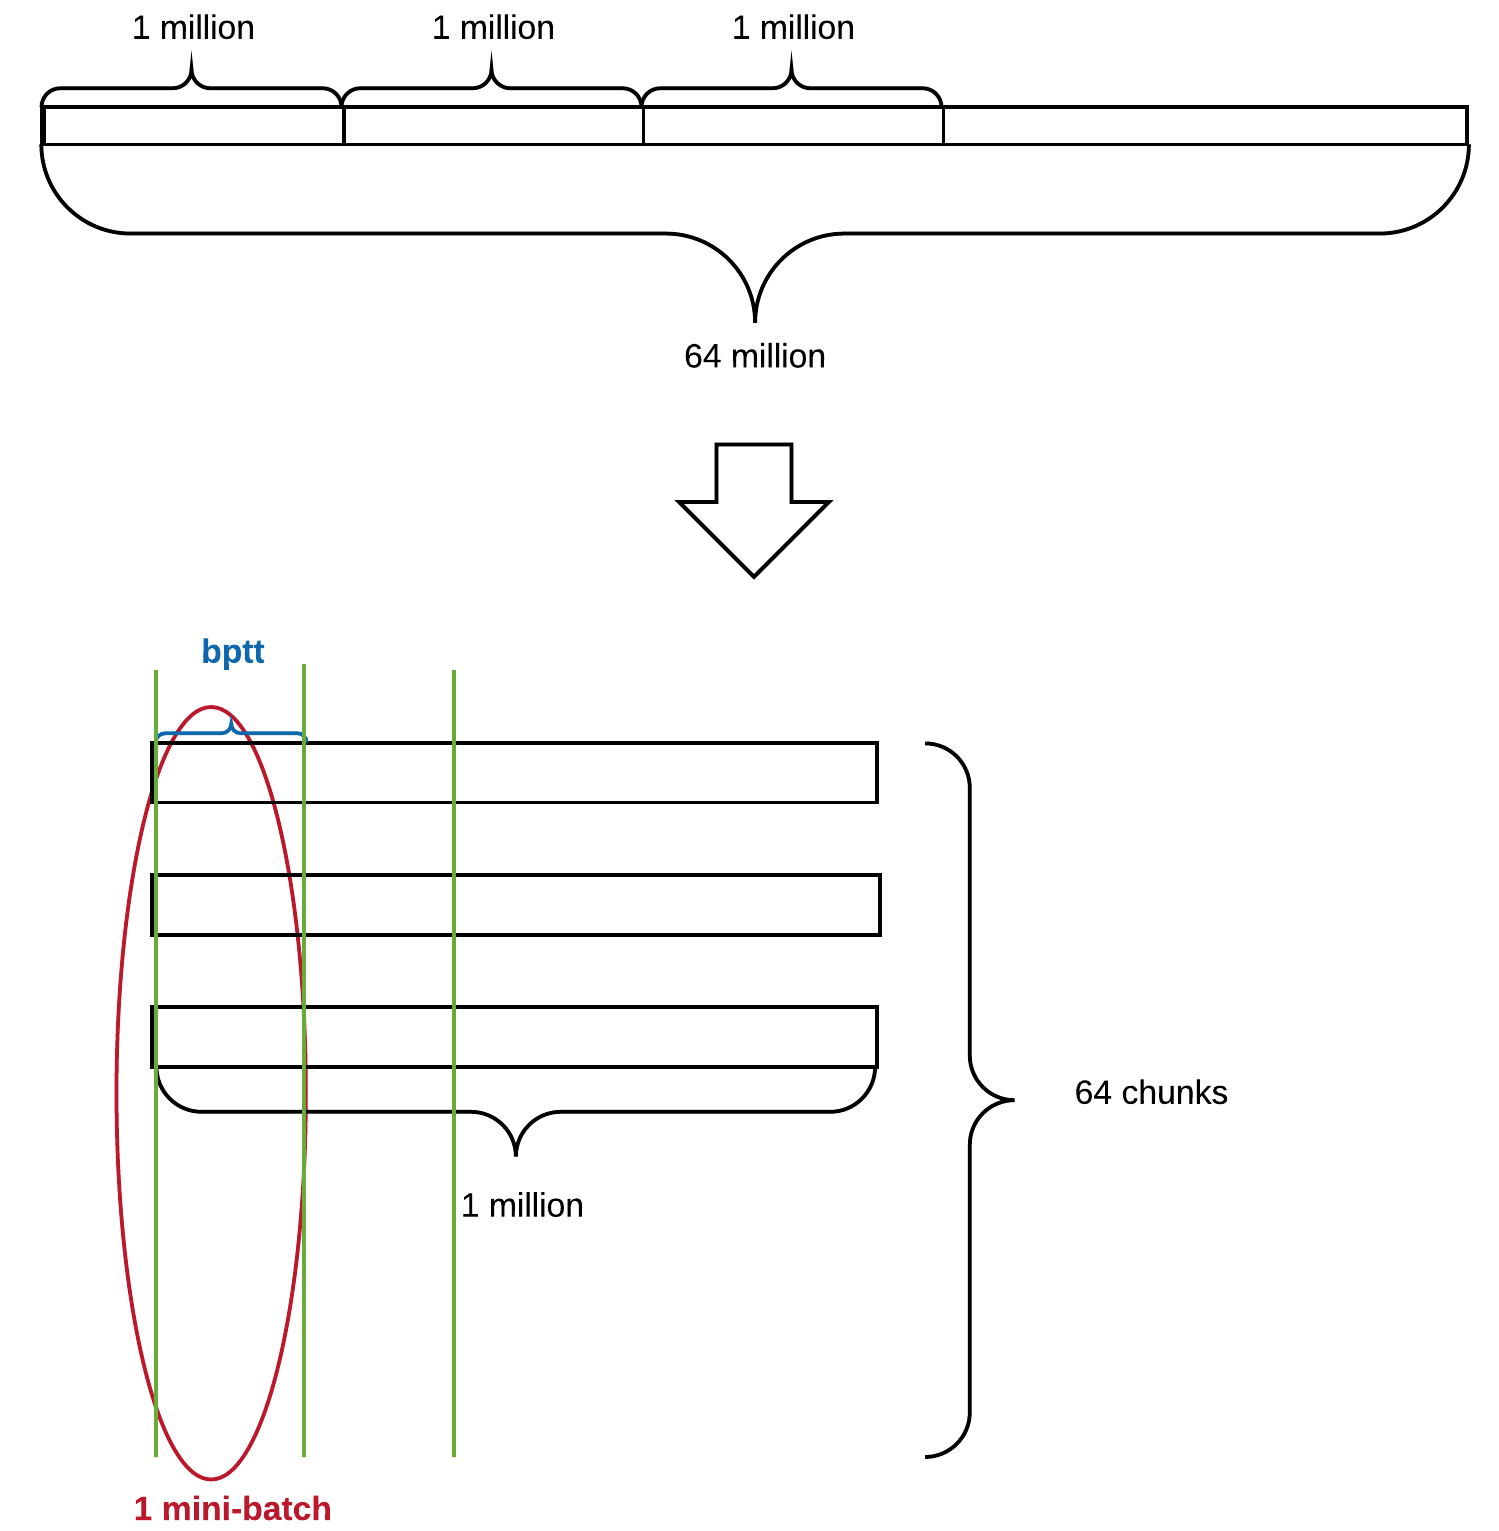

In [97]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden) # n_hidden=256
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs): #  cs: (length of bptt, batch_size). It does not always give us exactly 8 character. We cannot shuffle the data since it needs to be contiguous, so this is a way to introduce some randomness.
        bs = cs[0].size(0) # 64
        
        # The very last mini-batch will be shorter, but most datasets are usually not evently divisible. As a result, we add an check.
        # And then will reset at the start of the next epoch.
        if self.h.size(1) != bs: self.init_hidden(bs) # This happens at the end of the epoch and the beginning of the epoch (setting back to the full batch size).  It is very likely that the last mini-batch is shorter than the rest.
            
        outp,h = self.rnn(self.e(cs), self.h) # [len(cs), batch size, n_hidden], [1, batch size, n_hidden]
        
        # Back-prop through time (bptt)
        # If we had a 1 million character long text, we would have a 1 million layer fully connected network. It's a lot of computation.
        # Another reason not to backprop all the way back is because of exploding gradients; more layers, more chances the gradients will go through the roof.
                
        self.h = repackage_var(h) # Wraps h in new Variables, to detach them from their history. Therefore when it tries to back-propagate, it will stop there
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size) # [len(cs), batch size, vocab size] -> [len(cs) * batch_size, vocab_size]
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [98]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda() # md.nt = vocab_size = 85
opt = optim.Adam(m.parameters(), 1e-3)

In [99]:
it = iter(md.trn_dl) 
*xs,yt = next(it)  # [sequence length(bptt size), batch_size], [sequence length(bptt size) * batch_size]

In [100]:
t = m.e(V(*xs))
t.size() # [sequence length(bptt size), batch_size, n_fac]

torch.Size([19, 64, 42])

In [101]:
ht = V(torch.zeros(1, bs, n_hidden))
outp, hn = m.rnn(t, ht) 

outp.size(), hn.size() # [sequence length(bptt size), batch_size, n_hidden], [1, batch_size, n_hidden] 

(torch.Size([19, 64, 256]), torch.Size([1, 64, 256]))

In [102]:
t = m(*V(xs)); t.size() # [sequence length(bptt size) * batch_size, vocab_size]

torch.Size([1216, 55])

In [103]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.875481   1.850633  
    1      1.708709   1.710448                               
    2      1.621983   1.639342                              
    3      1.569348   1.596671                              



[1.5966707]

In [104]:
set_lrs(opt, 1e-4)

fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.490446   1.561823  
    1      1.497547   1.557513                              
    2      1.488089   1.548159                              
    3      1.484722   1.543567                              



[1.5435673]

### RNN loop

In [105]:
# From the pytorch source

def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh)) # tanh is preferrable in RNN (relu tends to lead to gradient explosion)

In [106]:
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden) # not layer 
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        
        # sequence size of RNN cells
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
            
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [107]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [108]:
it = iter(md.trn_dl) 
*xs,yt = next(it)  # [bptt size, batch_size], [bptt size * batch_size]

In [109]:
t = m.e(V(*xs))
t.size() # [bptt size, batch_size, n_fac]

torch.Size([13, 64, 42])

In [110]:
t = m(*V(xs)); t.size()  # [bptt size * batch_size, vocab_size]

torch.Size([832, 55])

In [111]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      1.882062   1.84373   
    1      1.717248   1.699499                               
    2      1.624917   1.634111                               
    3      1.578993   1.599874                               



[1.5998743]

### GRU

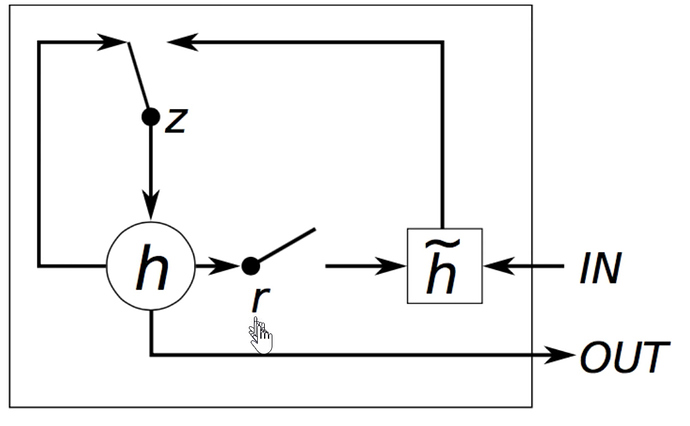

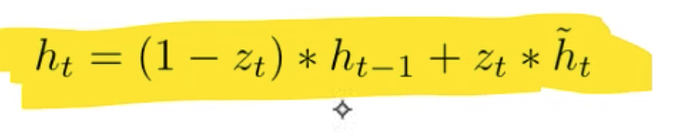

h_t-1: the hidden state as-is, h_t~: the updated hidden state.

In [113]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs): # cs: (bptt size, batch_size)
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [ ]:
# From the pytorch source code - for reference

def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)

In [114]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [115]:
it = iter(md.trn_dl) 
*xs,yt = next(it)  # [bptt size, batch_size], [bptt size * batch_size]

In [116]:
t = m.e(V(*xs))
t.size() # [bptt size, batch_size, n_fac]

torch.Size([6, 64, 42])

In [117]:
ht = V(torch.zeros(1, bs, n_hidden))
outp, hn = m.rnn(t, ht) 

outp.size(), hn.size() # [bptt size, batch_size, n_hidden], [1, batch_size, n_hidden]

(torch.Size([6, 64, 256]), torch.Size([1, 64, 256]))

In [118]:
t = m(*V(xs)); t.size() # [bptt size * batch_size, vocab_size]

torch.Size([384, 55])

In [119]:
fit(m, md, 6, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.75744    1.738142  
    1      1.577369   1.587712                              
    2      1.496674   1.52251                               
    3      1.442333   1.495559                              
    4      1.4051     1.476316                              
    5      1.37295    1.467871                              



[1.467871]

In [120]:
set_lrs(opt, 1e-4)

In [121]:
fit(m, md, 3, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.284021   1.428597  
    1      1.288709   1.427268                              
    2      1.28752    1.428281                              



[1.428281]

### Putting it all together: LSTM

In [122]:
from fastai import sgdr

n_hidden=512

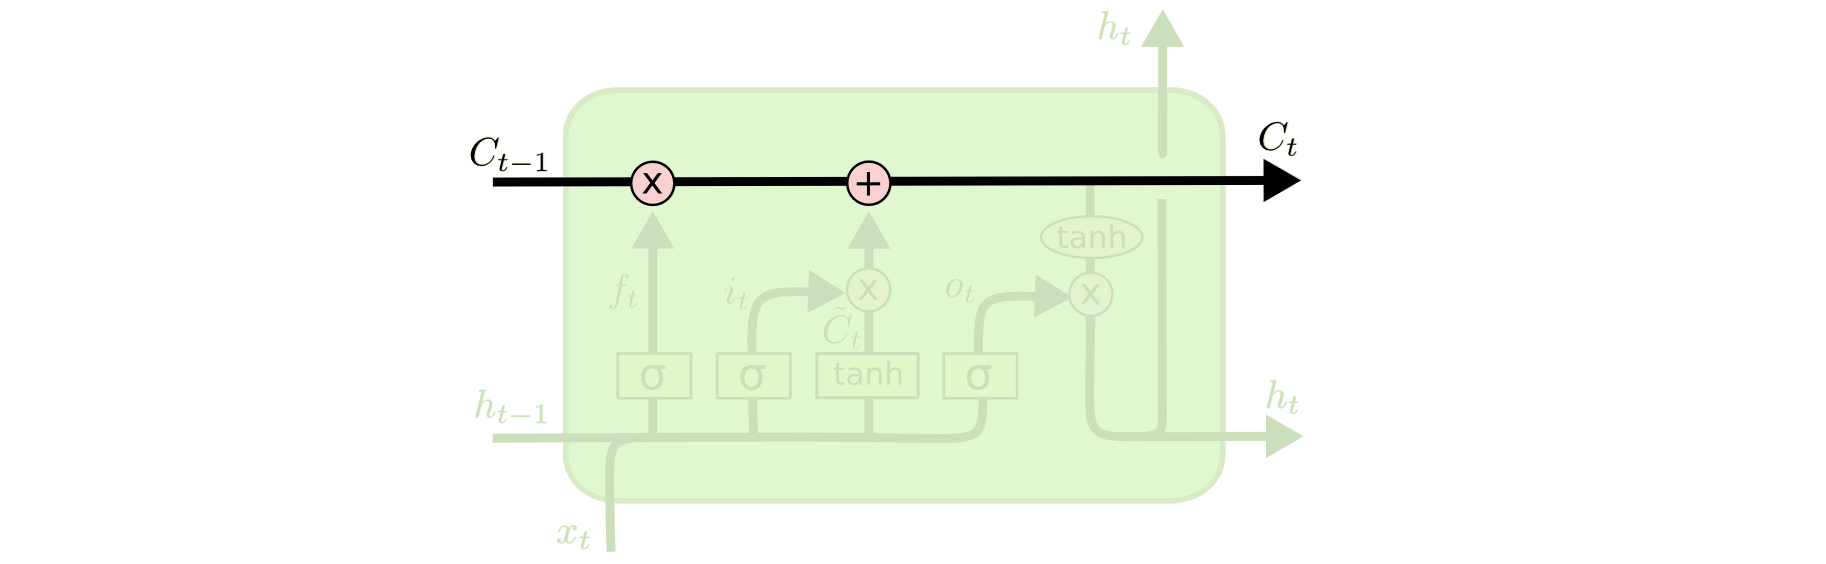

In [123]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl): # nl: Number of recurrent layers.
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h) # [len(cs), batch size, n_hidden], [[nl, batch size, n_hidden], [nl, batch size, n_hidden] <- hidden state and cell state
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

In [124]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [125]:
it = iter(md.trn_dl) 
*xs,yt = next(it)  # [bptt size, batch_size], [bptt size * batch_size]

In [126]:
t = m.e(V(*xs))
t.size() # [sequence length, batch_size, n_fac]

torch.Size([15, 64, 42])

In [128]:
ht = [V(torch.zeros(2, bs, n_hidden)), V(torch.zeros(2, bs, n_hidden))] # 2: number of layers
outp, hn = m.rnn(t, ht) 

outp.size(), len(hn), hn[0].size() # [bptt size, batch_size, n_hidden], 2, [nl, batch_size, n_hidden] 

(torch.Size([15, 64, 512]), 2, torch.Size([2, 64, 512]))

In [129]:
t = m(*V(xs)); t.size() # [bptt size * batch_size, vocab_size]

torch.Size([960, 55])

In [130]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [131]:
fit(m, md, 2, lo.opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.853017   1.752266  
    1      1.744228   1.656833                              



[1.6568329]

In [132]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.568813   1.51058   
    1      1.614395   1.545442                              
    2      1.48235    1.443336                              
    3      1.628381   1.569211                              
    4      1.550076   1.500372                              
    5      1.46878    1.435716                              
    6      1.410183   1.395792                              
    7      1.604856   1.550371                              
    8      1.572372   1.520342                              
    9      1.537798   1.489612                              
    10     1.490645   1.461064                              
    11     1.451873   1.426339                              
    12     1.404698   1.398105                              
    13     1.370945   1.375925                              
    14     1.332282   1.358136                              



[1.3581357]

In [133]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]
fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=63), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.324905   1.355405  
    1      1.33043    1.357278                              
    2      1.317799   1.353279                              
    3      1.325227   1.353176                              
    4      1.315197   1.351054                              
    5      1.304306   1.347587                              
    6      1.303983   1.349982                              
    7      1.303675   1.346347                              
    8      1.299536   1.345356                              
    9      1.29064    1.344319                              
    10     1.283517   1.335772                              
    11     1.282265   1.337728                              
    12     1.274204   1.335008                              
    13     1.276767   1.339229                              
    14     1.272989   1.332984                              
    15     1.276907   1.343615                      

[1.3769841]

### Test

In [134]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1))) # transpose(): The given dimensions dim0 and dim1 are swapped.
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [135]:
get_next('for thos')

'e'

In [136]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [137]:
print(get_next_n('for thos', 400))

for those likewime, thereforth withhacked by this,has something, the goethe from a upon which take and never teachers may be essentially when friends or decided and basesthypoch, anydomains, landerd'less conmented in anything to be a display as kind only that noble: thus! itwaythan is now attained, and, love, whocomplacents than is unbreakers of indeed, something life, intellectual fromso. "idagates?--fil
